### Bayesian optimization

Optimize our AE using a bayesian optimization, with the AUC as the 'score' to regress upon

##### imports

Import `skopt`

In [1]:
import autoencodeSVJ.evaluate as ev
import autoencodeSVJ.utils as utils
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
import numpy as np

Using TensorFlow backend.


In [2]:
space = [
    Real(0.00001, 0.001, name='learning_rate', prior='uniform'), 
    Integer(1, 20, name='es_patience')
]

In [3]:
filtered = utils.summary().cfilter([elt.name for elt in space] + ["*auc", "total_loss"])
filtered = filtered[~filtered.total_loss.isna()]

keep = filtered.copy()
for elt in space:
    if isinstance(elt, Categorical):
        keep = keep[keep[elt.name].isin(elt.categories)]
    else:
        keep = keep[keep[elt.name].between(*elt.bounds)]
        if isinstance(elt, Integer):
            keep = keep[keep[elt.name].apply(lambda x: float(x).is_integer())]
            keep[elt.name] = keep[elt.name].astype(int)

aucs = keep.loc[:,~keep.columns.isin([elt.name for elt in space])]

# x0 = np.asarray([keep[item.name].values for item in space]).T.tolist()
x0 = keep[[elt.name for elt in space]].values.tolist()
y0 = keep.total_loss.values.tolist()
# x0 = [list(keep [item.name].values) for item in space]
# y0 = auc.max(axis=1).tolist()

In [5]:
# random_state = 42

@use_named_args(space)
def objective(**X):
    print("computing configuration {}".format(X))
    
    # minimize 1 - auc
    loss = ev.ae_train(
        qcd_path='data/background/base_{}/*.h5'.format(3),
        signal_path="data/signal/base_{}/*.h5".format(3),
        epochs=100,
        hlf=1,w
        eflow=1,
        target_dim=7,
        learning_rate=X['learning_rate'],
        optimizer='adam',
        es_patience=X['es_patience'],
        loss='mse',
        norm_percentile=25,
        verbose=0,
        lr_factor=.999
    )
    
    print("Min loss: {}".format(loss))
    return loss

results = gp_minimize(
    objective, space, verbose=1,
    n_calls=1,
    n_random_starts=1,
    x0=x0,
    y0=y0
)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0023
Function value obtained: 0.0126
Current minimum: 0.0050
computing configuration {'learning_rate': 0.00057394813622007495, 'es_patience': 19}
training under filename 'hlf_eflow3_7_v499'
Min loss: 0.00539618104061
Iteration No: 2 ended. Search finished for the next optimal point.
Time taken: 200.8557
Function value obtained: 0.0054
Current minimum: 0.0050


In [7]:
@use_named_args(space)
def objective(**X):
    print "computing configuration {}".format(X)
    
    # minimize 1 - auc
    auc = 1. - ev.ae_train(
        qcd_path='data/background/base_{}/*.h5'.format(X['eflow_base']),
        signal_path="data/signal/base_{}/*.h5".format(X['eflow_base']),
        epochs=100,
        hlf=X['hlf'],
        eflow=1,
        target_dim=X['target_dim'],
#         val_split=X['val_split'],
        learning_rate=X['learning_rate'],
        optimizer='adam',
        loss=X['loss'],
#         loss='mse',
        seed=random_state,
        norm_args={
            'norm_type': X['norm_type'],
        },
        verbose=0,
    )
    
    print "Max AUC:", 1 - auc
    return auc

results2 = gp_minimize(
    objective, space, verbose=1, 
    n_calls=100, 
    n_random_starts=5, 
    random_state=42
)ff

SyntaxError: invalid syntax (<ipython-input-7-3b0400c6744e>, line 33)

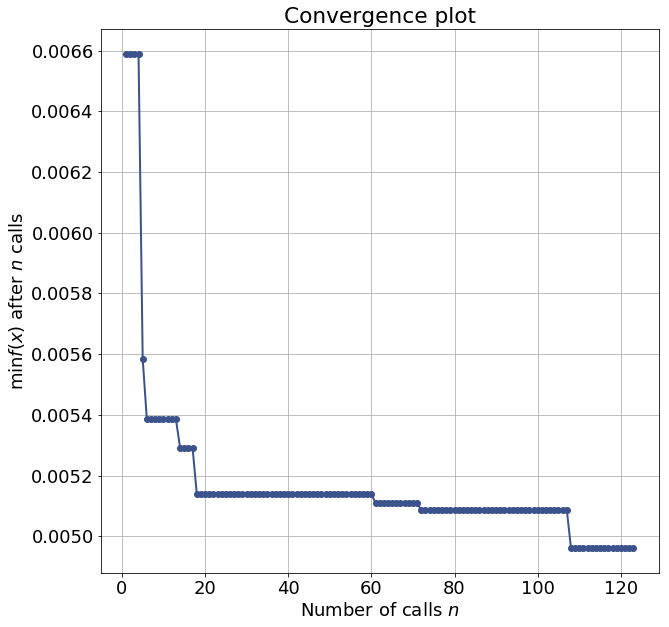

In [8]:
from skopt.plots import plot_convergence
import matplotlib.pyplot as plt

plot_convergence(results)
plt.show()

          fun: 0.0049613061441321927
    func_vals: array([ 0.00658903,  0.01187217,  0.00667913,  0.01150908,  0.00558426,
        0.00538521,  0.00681389,  0.01323275,  0.01196512,  0.00558245,
        0.01201474,  0.00612623,  0.00568618,  0.00529099,  0.00539705,
        0.00597127,  0.00559176,  0.00514092,  0.0126481 ,  0.01272813,
        0.00564465,  0.00614694,  0.00612202,  0.02311752,  0.01206346,
        0.00519618,  0.00562978,  0.00522323,  0.01426336,  0.00546908,
        0.00514074,  0.01273385,  0.02207674,  0.01710697,  0.01085773,
        0.00742444,  0.00594152,  0.00696224,  0.01211773,  0.01394659,
        0.01891357,  0.01069194,  0.03363535,  0.01224543,  0.01568612,
        0.00514189,  0.00544532,  0.02200527,  0.02223681,  0.02003291,
        0.02444473,  0.01301668,  0.03850723,  0.00955541,  0.0056855 ,
        0.00793226,  0.00592192,  0.00579261,  0.00603665,  0.01157019,
        0.00510902,  0.00570772,  0.00808329,  0.00587211,  0.01273929,
        0.00

In [9]:
print "Best parameters:"
for i,elt in enumerate(space):
    print "{} = {}".format(elt.name, results.x[i])

Best parameters:
learning_rate = 0.0006
es_patience = 12


In [11]:
results.x

[0.0006, 12]

In [14]:
e = ev.ae_evaluation("hlf_eflow3_8_v19")

found 1 matches with search '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/autoencode/data/summary/hlf_eflow3_8_v19.summary'


KeyboardInterrupt: 

In [1]:
import autoencodeSVJ.utils as utils

In [4]:
utils.summary().cfilter(['batch_size', 'mae_auc', 'filename', 'target_dim', 'learning_rate', 'input_dim', 'VID', 'arch']).sort_values('mae_auc')[::-1]

,VID,arch,batch_size,filename,input_dim,learning_rate,mae_auc,target_dim
107,5,"[19, 200, 10, 200, 19]",64,hlf_eflow3_10_v4,19,0.0001,0.904568,10
108,5,"[42, 200, 12, 200, 42]",64,hlf_eflow4_12_v1,42,0.0001,0.901751,12
101,5,"[19, 30, 30, 8, 30, 30, 19]",64,hlf_eflow3_8_v19,19,0.0005,0.895509,8
56,5,"[19, 30, 30, 20, 30, 30, 19]",64,hlf_eflow3_20_v18,19,0.0001,0.889205,20
69,5,"[19, 30, 30, 20, 30, 30, 19]",64,hlf_eflow3_20_v29,19,0.0001,0.889205,20
80,5,"[19, 30, 30, 20, 30, 30, 19]",64,hlf_eflow3_20_v40,19,0.0001,0.889205,20
79,5,"[19, 30, 30, 20, 30, 30, 19]",64,hlf_eflow3_20_v39,19,0.0001,0.889205,20
78,5,"[19, 30, 30, 20, 30, 30, 19]",64,hlf_eflow3_20_v38,19,0.0001,0.889205,20
77,5,"[19, 30, 30, 20, 30, 30, 19]",64,hlf_eflow3_20_v37,19,0.0001,0.889205,20
76,5,"[19, 30, 30, 20, 30, 30, 19]",64,hlf_eflow3_20_v36,19,0.0001,0.889205,20
